# Training Model for Quora Question Pairs's Training Dataset:

In [1]:
# avoid decoding problems
import sys
import os 
import pandas as pd
import numpy as np
from tqdm import tqdm
df = pd.read_csv("train.csv")
 
# encode questions to unicode
df['question1'] = df['question1'].apply(lambda x: unicode(str(x),"utf-8"))
df['question2'] = df['question2'].apply(lambda x: unicode(str(x),"utf-8"))

In [2]:
df.head()

,id,qid1,qid2,question1,question2,is_duplicate
0,0,1,2,What is the step by step guide to invest in sh...,What is the step by step guide to invest in sh...,0
1,1,3,4,What is the story of Kohinoor (Koh-i-Noor) Dia...,What would happen if the Indian government sto...,0
2,2,5,6,How can I increase the speed of my internet co...,How can Internet speed be increased by hacking...,0
3,3,7,8,Why am I mentally very lonely? How can I solve...,Find the remainder when [math]23^{24}[/math] i...,0
4,4,9,10,"Which one dissolve in water quikly sugar, salt...",Which fish would survive in salt water?,0


- It is a better choice to go further with TF-IDF scoring. 
- For TF-IDF, I used scikit-learn (heaven of ML).  
- It provides TfIdfVectorizer which does everything you need.
- here we use a pre-trained GLOVE model which comes free with "Spacy". 
- It is trained on Wikipedia and therefore, it is stronger in terms of word semantics. 

In [2]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer
# merge texts
questions = list(df['question1']) + list(df['question2'])

tfidf = TfidfVectorizer(lowercase=False, )
tfidf.fit_transform(questions)

# dict key:word and value:tf-idf score
word2tfidf = dict(zip(tfidf.get_feature_names(), tfidf.idf_))

- After we find TF-IDF scores, we convert each question to a weighted average of word2vec vectors by these scores. - The below code does this for "question1" and "question2" columns.
- This is how we use Spacy for this purpose.

In [3]:
# exctract word2vec vectors
import spacy

nlp = spacy.load('en')

vecs1 = []
for qu1 in tqdm(list(df['question1'])):
    doc1 = nlp(qu1) 
    mean_vec1 = np.zeros([len(doc1), 300])
    for word1 in doc1:
        # word2vec
        vec1 = word1.vector
        # fetch df score
        try:
            idf = word2tfidf[str(word1)]
        except:
            #print word
            idf = 0
        # compute final vec
        mean_vec1 += vec1 * idf
    mean_vec1 = mean_vec1.mean(axis=0)
    vecs1.append(mean_vec1)
df['q1_feats_m'] = list(vecs1)


100%|██████████| 404290/404290 [08:32<00:00, 788.17it/s]


In [4]:
vecs2 = []
for qu2 in tqdm(list(df['question2'])):
    doc2 = nlp(qu2) 
    mean_vec2 = np.zeros([len(doc2), 300])
    for word2 in doc2:
        # word2vec
        vec2 = word2.vector
        # fetch df score
        try:
            idf = word2tfidf[str(word2)]
        except:
            #print word
            idf = 0
        # compute final vec
        mean_vec2 += vec2 * idf
    mean_vec2 = mean_vec2.mean(axis=0)
    vecs2.append(mean_vec2)
df['q2_feats_m'] = list(vecs2)

100%|██████████| 404290/404290 [08:34<00:00, 785.93it/s]


- Reading the Features (Explored in EDA) like : preprocessing features and NLP features

In [7]:
import sys
reload(sys)
sys.setdefaultencoding('utf-8')

In [7]:

from sklearn.metrics.pairwise import cosine_similarity
q1_m=df['q1_feats_m'].values
q2_m=df['q2_feats_m'].values


#df['cosine']=np.array([cosine_similarity(q1_m[i],q2_m[i]) for i in range(0,len(q1_m))])

In [8]:
from sklearn.metrics.pairwise import pairwise_distances
#df['eucld_dis'] = pairwise_distances(q1_m,q2_m , metric='euclidean', n_jobs=1)
#df['eucld_dis'] = df.apply(lambda row: pairwise_distances(row["q1_feats_m"].values, row["q2_feats_m"].values, metric='euclidean', n_jobs=1), axis=1)

In [ ]:
df['cosine_dis'] = df.apply(lambda row: pairwise_distances(row["q1_feats_m"], row["q2_feats_m"], metric='cosine', n_jobs=1), axis=1)

df['manhattan_dis'] = df.apply(lambda row: pairwise_distances(row["q1_feats_m"], row["q2_feats_m"], metric='manhattan', n_jobs=1), axis=1)

In [9]:
import scipy.spatial.distance

df1 = pd.DataFrame()

df1['braycurtis_dis'] = df.apply(lambda row: scipy.spatial.distance.braycurtis(row["q1_feats_m"], row["q2_feats_m"]), axis=1)

df1['canberra_dis'] = df.apply(lambda row: scipy.spatial.distance.canberra(row["q1_feats_m"], row["q2_feats_m"]), axis=1)

df1['chebyshev_dis'] = df.apply(lambda row: scipy.spatial.distance.chebyshev(row["q1_feats_m"], row["q2_feats_m"]), axis=1)

df1['cityblock_dis'] = df.apply(lambda row: scipy.spatial.distance.cityblock(row["q1_feats_m"], row["q2_feats_m"]), axis=1)

df1['correlation_dis'] = df.apply(lambda row: scipy.spatial.distance.correlation(row["q1_feats_m"], row["q2_feats_m"]), axis=1)

df1['cosine_dis'] = df.apply(lambda row: scipy.spatial.distance.cosine(row["q1_feats_m"], row["q2_feats_m"]), axis=1)

df1['euclidean_dis'] = df.apply(lambda row: scipy.spatial.distance.euclidean(row["q1_feats_m"], row["q2_feats_m"]), axis=1)

#df['mahalanobis_dis'] = df.apply(lambda row: scipy.spatial.distance.mahalanobis(row["q1_feats_m"], row["q2_feats_m"]), axis=1)

df1['minkowski_dis'] = df.apply(lambda row: scipy.spatial.distance.minkowski(row["q1_feats_m"], row["q2_feats_m"], 3), axis=1)

#df['seuclidean_dis'] = df.apply(lambda row: scipy.spatial.distance.seuclidean(row["q1_feats_m"], row["q2_feats_m"]), axis=1)

df1['sqeuclidean_dis'] = df.apply(lambda row: scipy.spatial.distance.sqeuclidean(row["q1_feats_m"], row["q2_feats_m"]), axis=1)

#df['wminkowski_dis'] = df.apply(lambda row: scipy.spatial.distance.wminkowski(row["q1_feats_m"], row["q2_feats_m"]), axis=1)

df1['hamming_dis'] = df.apply(lambda row: scipy.spatial.distance.hamming(row["q1_feats_m"], row["q2_feats_m"]), axis=1)


In [10]:
df1.head()


,braycurtis_dis,canberra_dis,chebyshev_dis,cityblock_dis,correlation_dis,cosine_dis,euclidean_dis,minkowski_dis,sqeuclidean_dis,hamming_dis
0,0.033526,29.418519,6.501952,158.116874,0.001011,0.001012,12.871938,7.496870,165.686783,1.0
1,0.515475,173.066755,79.473514,1468.718965,0.209615,0.211893,135.934008,88.790428,18478.054406,1.0
2,0.282911,128.748397,18.491902,1137.846965,0.078117,0.078275,85.572404,39.782522,7322.636355,1.0
3,0.668339,199.018340,50.365853,1821.904978,0.280281,0.282520,143.185040,73.653511,20501.955571,1.0
4,0.453698,166.270553,40.897270,2083.473957,0.201416,0.202895,149.786324,68.844244,22435.942710,1.0


In [18]:
import gensim.models

In [31]:
#word2vec_model = gensim.models.KeyedVectors.load_word2vec_format('GoogleNews-vectors-negative300.bin', binary=True)
#word2vec_model.init_sims(replace=True) 
# normalizes vectors
# Compute WMD as normal.
#distance = word2vec_model.wmdistance("string 1".split(), "string 2".split())



In [30]:
#from pyemd import wmdistance
#df1['word_mover_dis'] = df.apply(lambda row: word2vec_model.wmdistance(row['question1'].split(), row['question2'].split()), axis=1)

In [25]:
df1.head()

,braycurtis_dis,canberra_dis,chebyshev_dis,cityblock_dis,correlation_dis,cosine_dis,euclidean_dis,minkowski_dis,sqeuclidean_dis,hamming_dis
0,0.033526,29.418519,6.501952,158.116874,0.001011,0.001012,12.871938,7.496870,165.686783,1.0
1,0.515475,173.066755,79.473514,1468.718965,0.209615,0.211893,135.934008,88.790428,18478.054406,1.0
2,0.282911,128.748397,18.491902,1137.846965,0.078117,0.078275,85.572404,39.782522,7322.636355,1.0
3,0.668339,199.018340,50.365853,1821.904978,0.280281,0.282520,143.185040,73.653511,20501.955571,1.0
4,0.453698,166.270553,40.897270,2083.473957,0.201416,0.202895,149.786324,68.844244,22435.942710,1.0


In [26]:
df1.to_csv("W2V_vec_distance_features_train1.csv", index=False)

In [29]:
#import numpy.linalg
#df["q1_inverse"] = df.apply(lambda row: numpy.linalg.inv(row["q1_feats_m"]), axis=1)
#df["q2_inverse"] = df.apply(lambda row: numpy.linalg.inv(row["q2_feats_m"]), axis=1)

In [27]:
#df.to_csv("wtov_mean_features_train.csv", index=False)

In [5]:
#prepro_features_train.csv (Simple Preprocessing Feartures)
#nlp_features_train.csv (NLP Features)
dfnlp = pd.read_csv("df1_nlp1_features.csv")
dfppro = pd.read_csv("df1_preprocessing1_features.csv")
dfw2v = pd.read_csv("W2V_vec_distance_features_train1.csv")

#dfnlp.shape

In [7]:
dfnlp.shape

(404290, 48)

In [8]:
dfppro.head()

,freq_qid1,freq_qid2,q1len,q2len,q1_n_words,q2_n_words,word_Common,word_Total,word_share,freq_q1+q2,freq_q1-q2,capital_1,capital_2,capital_total,capital_diff,bigram_common,bigram_total,bigram_ratio,tfidf,tfidf_unigram_word_match
0,1,1,66,57,14,12,10.0,23.0,0.434783,2,0,1.0,1.0,2.0,0.0,11.0,15.0,0.733333,"(0, 77556)\t0.0756699844518\n (0, 35701)\t0...",0.966742
1,4,1,51,88,8,13,4.0,20.0,0.200000,5,3,5.0,5.0,10.0,0.0,6.0,23.0,0.260870,"(0, 77556)\t0.0701848729964\n (0, 35701)\t0...",0.650728
2,1,1,73,59,14,10,4.0,24.0,0.166667,2,0,5.0,5.0,10.0,0.0,1.0,23.0,0.043478,"(0, 70831)\t0.0540481138459\n (0, 10064)\t0...",0.301877
3,1,1,50,65,11,9,0.0,19.0,0.000000,2,0,4.0,1.0,5.0,3.0,0.0,23.0,0.000000,"(0, 35701)\t0.0668356636523\n (0, 70831)\t0...",0.000000
4,3,1,76,39,13,7,2.0,20.0,0.100000,4,2,1.0,1.0,2.0,0.0,0.0,22.0,0.000000,"(0, 33839)\t0.116120577565\n (0, 78429)\t0....",0.293379


In [10]:
dfnlp.head()

,cwc_min,cwc_max,csc_min,csc_max,ctc_min,ctc_max,last_word_eq,first_word_eq,abs_len_diff,mean_len,token_set_ratio,token_sort_ratio,fuzz_ratio,fuzz_partial_ratio,longest_substr_ratio
0,0.999980,0.833319,0.999983,0.999983,0.916659,0.785709,0.0,1.0,2.0,13.0,100,93,93,100,0
1,0.799984,0.399996,0.749981,0.599988,0.699993,0.466664,0.0,1.0,5.0,12.0,86,63,66,75,0
2,0.399992,0.333328,0.399992,0.249997,0.399996,0.285712,0.0,1.0,4.0,12.0,63,63,43,47,0
3,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,2.0,12.0,28,24,9,14,0
4,0.399992,0.199998,0.999950,0.666644,0.571420,0.307690,0.0,1.0,6.0,10.0,67,47,35,56,0


In [6]:
#all_feats = np.concatenate()

#frames = [df, dfppro, dfnlp]

df_all_features = pd.concat([dfppro, dfnlp, dfw2v], axis=1)
df_all_features.shape

(404290, 80)

In [10]:
df_all_features.head()

,freq_qid1,freq_qid2,q1len,q2len,q1_n_words,q2_n_words,word_Common,word_Total,word_share,freq_q1+q2,...,chebyshev_dis,cityblock_dis,correlation_dis,cosine_dis,euclidean_dis,minkowski_dis,sqeuclidean_dis,hamming_dis,q1_pr,q2_pr
0,1,1,66,57,14,12,10.0,23.0,0.434783,2,...,6.501952,158.116874,0.001011,0.001012,12.871938,7.496870,165.686783,1.0,1.608480e-07,3.047631e-07
1,4,1,51,88,8,13,4.0,20.0,0.200000,5,...,79.473514,1468.718965,0.209615,0.211893,135.934008,88.790428,18478.054406,1.0,8.198776e-07,3.097268e-07
2,1,1,73,59,14,10,4.0,24.0,0.166667,2,...,18.491902,1137.846965,0.078117,0.078275,85.572404,39.782522,7322.636355,1.0,3.049200e-07,1.609126e-07
3,1,1,50,65,11,9,0.0,19.0,0.000000,2,...,50.365853,1821.904978,0.280281,0.282520,143.185040,73.653511,20501.955571,1.0,2.088105e-07,2.088105e-07
4,3,1,76,39,13,7,2.0,20.0,0.100000,4,...,40.897270,2083.473957,0.201416,0.202895,149.786324,68.844244,22435.942710,1.0,3.406708e-07,1.278450e-07


In [7]:
#W2V Question1 Vector
Q1_vec = df['q1_feats_m'].values
#W2V Question2 Vector
Q2_vec = df['q2_feats_m'].values
#Features Extracted in EDA
feat_80 = df_all_features.values

In [14]:
a = [1,2,3]
b = [2,3,4]
c = [3,4]
np.concatenate((a,b,c))

sklearn.metrics.pairwise.pairwise_distances(X, Y=None, metric=’euclidean’, n_jobs=1, **kwds)

array([1, 2, 3, 2, 3, 4, 3, 4])

- Creating a Single vector with the combination of all 2 W2V vectors and all Features(26)
- "features"  : is the combined vectorof length 626 of all 3 thinngs

In [8]:
features = []
for i in range(0,len(Q1_vec)):
    Q1 = Q1_vec[i]
    Q2 = Q2_vec[i]
    f = feat_80[i]
    features.append(np.concatenate((Q1,Q2,f)))

In [9]:
features = np.array(features)
print len(features[0])
#print Q1_vec[0][0:15]
#print Q2_vec[0][0:15]
#print feat_26[0]
print len(features)

680
404290


- "lbl" = Lables Values or class 

In [10]:
lbl = df["is_duplicate"].values

- Splitting the train and test data into 80% and 20%

In [11]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.cross_validation import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.naive_bayes import MultinomialNB
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import SGDClassifier


#test_proportion of 3 would mean 1/3 so 33% test and 67% train
def shuffle(matrix, target, test_proportion):
    ratio = matrix.shape[0]/test_proportion
    X_train = matrix[ratio:,:]
    X_test =  matrix[:ratio,:]
    Y_train = target[ratio:]
    Y_test =  target[:ratio]
    return X_train, X_test, Y_train, Y_test
X_train, X_test, Y_train, Y_test = shuffle(features, lbl, 5)

/home/darshan_excellence/.local/lib/python2.7/site-packages/sklearn/cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


-Implementing Logistic Regression:

In [ ]:
#logistic regression

best_params_logreg = []
parameters = {'loss':['log'],'penalty':['l1','l2','elasticnet'],'alpha':[0.001,0.01,0.1,1,10,20,30,40,50,60,70,80,90,100], 'n_jobs':[-1]}

clf = SGDClassifier()
clf = GridSearchCV(clf,parameters,cv = 5)
clf.fit(X_train,Y_train)
best_params_logreg.append(clf.best_params_)
print best_params_logreg

In [40]:
#Do a test with cross validation
clf = SGDClassifier(loss= 'log',penalty = 'elasticnet',alpha = 0.01,n_jobs = -1)
#choose best parameters
score = cross_val_score(clf,X_train,Y_train,cv = 5)

In [41]:
#cross validation score. Test it
print sum(score)/len(score)

0.777294759058


In [50]:
#test set Prediction
from sklearn.metrics import confusion_matrix
clf.fit(X_train,Y_train)
Y_pred = clf.predict(X_test)
conf_log_ref = confusion_matrix(Y_test,Y_pred)

In [54]:
#confusion matrix
print conf_log_ref

[[48108  2599]
 [15690 14461]]


In [55]:
true = conf_log_ref[0][0]+conf_log_ref[1][1]
false = conf_log_ref[0][1]+conf_log_ref[1][0]
print "Test accuracy:",float(true)*100/(true+false)

Test accuracy: 77.3813351802


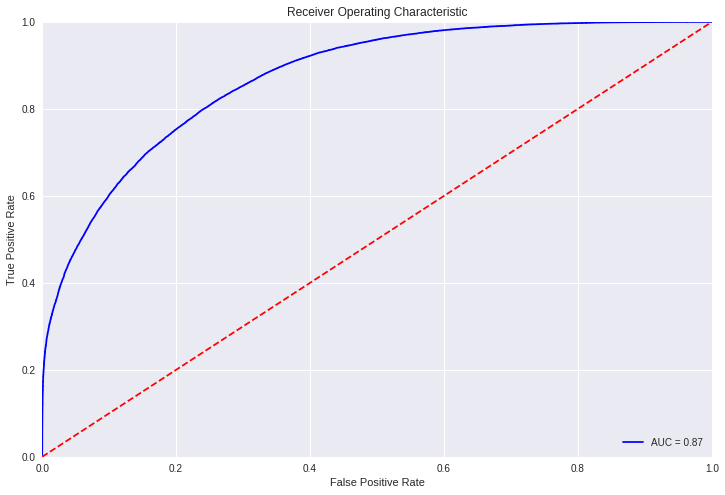

Precision : 84.7655334115
Recall : 47.9619249776


In [56]:
score_Log_reg = []

#ROC for a given alpha for log reg
from sklearn.metrics import roc_curve, auc
# Compute ROC curve and ROC area for each class
probs = clf.predict_proba(X_test)
preds = probs[:,1]
fpr, tpr, threshold = roc_curve(Y_test, preds)
roc_auc = auc(fpr, tpr)

#Plot ROC
import matplotlib.pyplot as plt
plt.figure(figsize=(12,8))
plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()





#Precision and recall
tn = conf_log_ref[0,0]; fp = conf_log_ref[0,1]; fn = conf_log_ref[1,0]; tp = conf_log_ref[1,1];

precision = 100*float(tp)/(tp+fp)
recall = 100*float(tp)/(tp+fn)

print "Precision :",precision
print "Recall :",recall


In [67]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os
import gc
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

Using XG-Boost for better result:

In [ ]:
#XG-Boost
import xgboost as xgb

In [ ]:
# Set our parameters for xgboost
parameters = {'nthread':[4], #when use hyperthread, xgboost may become slower
              'objective':['binary:logistic'],
              'learning_rate': [0.05], #so called `eta` value
              'max_depth': [6],
              'min_child_weight': [11],
              'silent': [1],
              'subsample': [0.8],
              'colsample_bytree': [0.7],
              'n_estimators': [5], #number of trees, change it to 1000 for better results
              'missing':[-999],
              'seed': [1337]}

d_train = xgb.DMatrix(X_train, label=Y_train)
d_valid = xgb.DMatrix(X_test, label=Y_test)

watchlist = [(d_train, 'train'), (d_valid, 'valid')]

bst = xgb.train(params, d_train, 400, watchlist, early_stopping_rounds=20, verbose_eval=10)



xgdmat = xgb.DMatrix(X_train, Y_train) # Create our DMatrix to make XGBoost more efficient
#Now let’s specify our parameters

[0]	train-logloss:0.684874	valid-logloss:0.68485
Multiple eval metrics have been passed: 'valid-logloss' will be used for early stopping.

Will train until valid-logloss hasn't improved in 20 rounds.
[10]	train-logloss:0.61497	valid-logloss:0.614961
[20]	train-logloss:0.564574	valid-logloss:0.564663
[30]	train-logloss:0.526446	valid-logloss:0.526749
[40]	train-logloss:0.497318	valid-logloss:0.497832
[50]	train-logloss:0.474221	valid-logloss:0.474874
[60]	train-logloss:0.455786	valid-logloss:0.456649
[70]	train-logloss:0.441134	valid-logloss:0.442104
[80]	train-logloss:0.429209	valid-logloss:0.430262
[90]	train-logloss:0.419703	valid-logloss:0.4208
[100]	train-logloss:0.411767	valid-logloss:0.412922
[110]	train-logloss:0.405076	valid-logloss:0.406258
[120]	train-logloss:0.399539	valid-logloss:0.400765
[130]	train-logloss:0.394769	valid-logloss:0.396019
[140]	train-logloss:0.390956	valid-logloss:0.392238
[150]	train-logloss:0.387527	valid-logloss:0.388846
[160]	train-logloss:0.384669	val

In [87]:
d_test = xgb.DMatrix(X_test)
Y_pred = bst.predict(d_test)
y_pred = Y_pred

In [88]:

print Y_pred
for i in range(0,len(Y_pred)):
    if Y_pred[i]>=0.5:
        Y_pred[i]=1
    else:
        Y_pred[i]=0
        

[ 0.40809453  0.28530639  0.12771755 ...,  0.71649224  0.86554301
  0.00338006]


In [89]:
conf_xgb = confusion_matrix(Y_test,Y_pred)
print conf_xgb

[[45598  5109]
 [ 9274 20877]]


In [90]:
true = conf_xgb[0][0]+conf_xgb[1][1]
false = conf_xgb[0][1]+conf_xgb[1][0]
print "Test accuracy with X-Gboost:",float(true)*100/(true+false)

Test accuracy with X-Gboost: 82.2120260209


In [91]:


#Precision and recall
tn = conf_xgb[0,0]; fp = conf_xgb[0,1]; fn = conf_xgb[1,0]; tp = conf_xgb[1,1];

precision = 100*float(tp)/(tp+fp)
recall = 100*float(tp)/(tp+fn)

print "Precision :",precision
print "Recall :",recall

Precision : 80.3394135304
Recall : 69.2414845279


In [92]:
#print(bst.feature_importances_)
feature_imp= bst.get_fscore(fmap='')

In [93]:
import operator
sorted_Fimp = sorted(feature_imp.items(), key=operator.itemgetter(1))

In [94]:
sorted_Fimp.reverse()
sorted_Fimp

[('f608', 758),
 ('f600', 468),
 ('f601', 444),
 ('f612', 440),
 ('f611', 367),
 ('f622', 293),
 ('f614', 235),
 ('f617', 234),
 ('f623', 202),
 ('f609', 191),
 ('f624', 150),
 ('f613', 110),
 ('f606', 108),
 ('f616', 104),
 ('f405', 59),
 ('f615', 55),
 ('f9', 51),
 ('f105', 50),
 ('f621', 50),
 ('f309', 42),
 ('f189', 40),
 ('f610', 36),
 ('f87', 33),
 ('f620', 33),
 ('f472', 32),
 ('f393', 30),
 ('f269', 25),
 ('f144', 24),
 ('f249', 23),
 ('f172', 22),
 ('f619', 20),
 ('f602', 20),
 ('f559', 19),
 ('f113', 19),
 ('f366', 19),
 ('f607', 19),
 ('f93', 18),
 ('f86', 18),
 ('f207', 18),
 ('f273', 17),
 ('f248', 17),
 ('f82', 16),
 ('f181', 16),
 ('f534', 16),
 ('f276', 15),
 ('f489', 15),
 ('f66', 14),
 ('f292', 13),
 ('f310', 12),
 ('f92', 12),
 ('f618', 12),
 ('f162', 12),
 ('f427', 11),
 ('f10', 11),
 ('f89', 11),
 ('f56', 11),
 ('f296', 11),
 ('f542', 10),
 ('f352', 10),
 ('f241', 10),
 ('f414', 10),
 ('f218', 10),
 ('f569', 9),
 ('f140', 9),
 ('f29', 9),
 ('f270', 8),
 ('f443', 8)